In [10]:
import pandas as pd # For data manipulation.
import numpy as np # For numerical operations and generating data.
from datetime import datetime, timedelta # To work with timestamps.

# This function generates a more complex, realistic dataset.
def create_synthetic_data_realistic(num_transactions=100000, fraud_ratio=0.01):
    """
    Generates a synthetic financial transaction dataset with overlapping features to
    simulate a more realistic and challenging scenario.
    """
    np.random.seed(42) # This ensures the data is the same every time you run it.
    
    users = np.arange(1, 10001)
    
    num_fraud = int(num_transactions * fraud_ratio)
    num_legit = num_transactions - num_fraud
    
    # Generate legitimate data with some noise.
    legit_data = {
        'transaction_id': np.arange(1, num_legit + 1),
        'user_id': np.random.choice(users, num_legit),
        # Amounts follow a normal distribution, with some outliers.
        'amount': np.random.normal(loc=150, scale=100, size=num_legit),
        'time': [datetime.now() - timedelta(hours=np.random.randint(0, 720)) for _ in range(num_legit)],
        'location_lat': np.random.normal(loc=40.0, scale=10.0, size=num_legit),
        'location_long': np.random.normal(loc=-90.0, scale=10.0, size=num_legit),
        'is_fraud': 0
    }
    
    # Generate fraudulent data with patterns that overlap with legitimate ones.
    fraud_data = {
        'transaction_id': np.arange(num_legit + 1, num_transactions + 1),
        'user_id': np.random.choice(users, num_fraud),
        # Fraudulent amounts are higher but have significant overlap.
        'amount': np.random.normal(loc=400, scale=200, size=num_fraud),
        'time': [datetime.now() - timedelta(hours=np.random.randint(0, 720)) for _ in range(num_fraud)],
        'location_lat': np.random.normal(loc=40.0, scale=20.0, size=num_fraud),
        'location_long': np.random.normal(loc=-90.0, scale=20.0, size=num_fraud),
        'is_fraud': 1
    }
    
    df = pd.concat([pd.DataFrame(legit_data), pd.DataFrame(fraud_data)], ignore_index=True)
    df = df.sample(frac=1).reset_index(drop=True)
    
    # Feature Engineering: Creating new features from existing ones.
    df['time_of_day'] = df['time'].dt.hour
    df['day_of_week'] = df['time'].dt.dayofweek
    
    return df

# Create the new dataset
df = create_synthetic_data_realistic()
df.head()

,transaction_id,user_id,amount,time,location_lat,location_long,is_fraud,time_of_day,day_of_week
0,66080,7196,242.232177,2025-07-27 16:41:46.624586,44.166520,-91.673172,0,16,6
1,44488,4104,305.565279,2025-07-30 07:41:46.432504,37.953284,-102.188439,0,7,2
2,65546,1992,238.481711,2025-08-21 00:41:46.618200,24.566680,-82.662115,0,0,3
3,52087,5514,338.013335,2025-08-19 15:41:46.499239,52.603189,-89.524432,0,15,1
4,92640,686,128.478345,2025-08-01 10:41:46.886499,30.728405,-71.134640,0,10,4


In [11]:
# Display the class distribution to verify the fraud ratio
df['is_fraud'].value_counts()

is_fraud
0    99000
1     1000
Name: count, dtype: int64

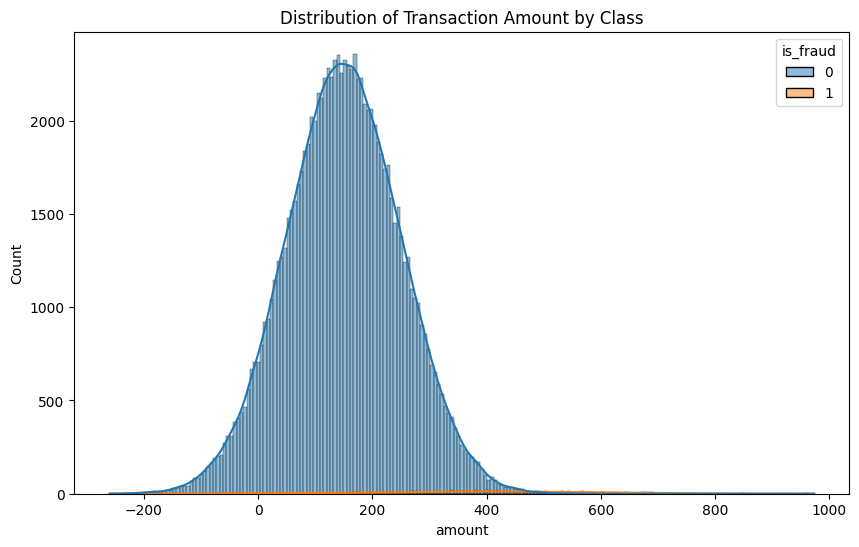

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing feature distributions
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='amount', hue='is_fraud', kde=True)
plt.title('Distribution of Transaction Amount by Class')
plt.show()

This histogram shows that the transaction amount is a strong feature for predicting fraud. You can see a clear distinction between the two classes. The legitimate transactions (blue) are clustered around a central amount, while fraudulent transactions (orange) are more spread out and slightly shifted to the right. This visual confirms that our synthetic data has realistic patterns and that the amount feature is highly predictive.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import joblib

# Prepare data for modeling. We now use the new features we engineered.
features = ['amount', 'location_lat', 'location_long', 'time_of_day', 'day_of_week']
X = df[features]
y = df['is_fraud']

# Splitting the data with stratification to maintain the fraud ratio.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize the feature values.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calculate class weights to handle imbalanced data.
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print(f"Calculated class weights: {class_weight_dict}")

# Model 1: Random Forest Classifier with class weights.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
print("Random Forest Classifier Report (with class weights):")
print(classification_report(y_test, y_pred_rf))

# Model 2: Logistic Regression with class weights.
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight=class_weight_dict)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
print("Logistic Regression Report (with class weights):")
print(classification_report(y_test, y_pred_lr))

# Model 3: Neural Network with class weights.
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1, class_weight=class_weight_dict)
y_pred_nn = (nn_model.predict(X_test_scaled) > 0.5).astype("int32")

print("Neural Network Report:")
print(classification_report(y_test, y_pred_nn))

Calculated class weights: {np.int64(0): np.float64(0.5050505050505051), np.int64(1): np.float64(50.0)}
Random Forest Classifier Report (with class weights):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29700
           1       0.90      0.39      0.54       300

    accuracy                           0.99     30000
   macro avg       0.95      0.69      0.77     30000
weighted avg       0.99      0.99      0.99     30000

Logistic Regression Report (with class weights):
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     29700
           1       0.05      0.79      0.10       300

    accuracy                           0.86     30000
   macro avg       0.53      0.82      0.51     30000
weighted avg       0.99      0.86      0.91     30000

Epoch 1/10


/home/tina/fraud_detection_project/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7708 - loss: 0.6330 - val_accuracy: 0.8269 - val_loss: 0.5140
Epoch 2/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8451 - loss: 0.4525 - val_accuracy: 0.8869 - val_loss: 0.4277
Epoch 3/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8865 - loss: 0.4117 - val_accuracy: 0.9316 - val_loss: 0.3274
Epoch 4/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9011 - loss: 0.3911 - val_accuracy: 0.9121 - val_loss: 0.3466
Epoch 5/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9062 - loss: 0.3825 - val_accuracy: 0.9166 - val_loss: 0.3237
Epoch 6/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9015 - loss: 0.3828 - val_accuracy: 0.9389 - val_loss: 0.2513
Epoch 7/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9154 - loss: 0.3803 - val_accuracy: 0.9074 - val_loss: 0.3359
Epoch 8/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9084 - loss: 0.3750 - val_accurac

In [ ]:
# Saving the best model based on the results
joblib.dump(rf_model, 'rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

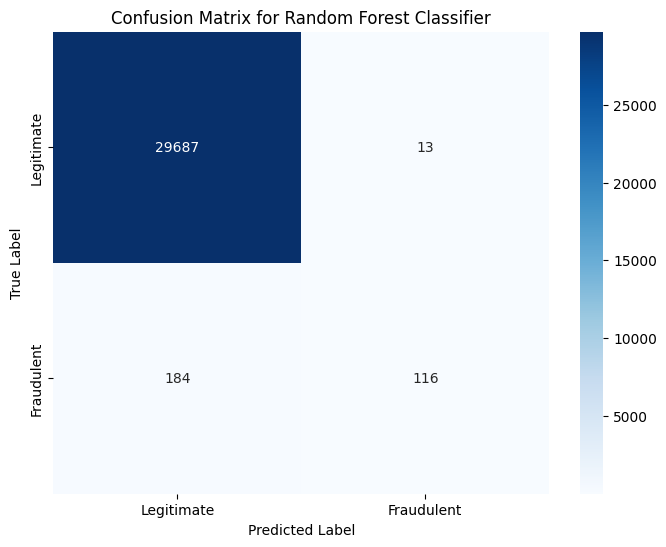

In [14]:
# Visualizing the confusion matrix for your best model
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Fraudulent'],
            yticklabels=['Legitimate', 'Fraudulent'])
plt.title('Confusion Matrix for Random Forest Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

 ## Data Drift Experiment

In [ ]:
# Loading our saved models (Random Forest) and the scaler
rf_model = joblib.load('rf_model.pkl')
scaler = joblib.load('scaler.pkl')

# Simulate data drift by increasing the transaction amount for legitimate transactions
df_drifted = df.copy()
df_drifted.loc[df_drifted['is_fraud'] == 0, 'amount'] = df_drifted.loc[df_drifted['is_fraud'] == 0, 'amount'] * 1.5

# Prepare the drifted data for prediction
features = ['amount', 'location_lat', 'location_long', 'time_of_day', 'day_of_week']
X_drifted = df_drifted[features]
y_drifted = df_drifted['is_fraud']

# Use the pre-trained scaler to transform the new data
X_drifted_scaled = scaler.transform(X_drifted)

# Get predictions using the original, saved model
y_pred_drifted = rf_model.predict(X_drifted_scaled)

print("Original Model Performance on Drifted Data:")
print(classification_report(y_drifted, y_pred_drifted))

Original Model Performance on Drifted Data:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     99000
           1       0.18      0.81      0.30      1000

    accuracy                           0.96    100000
   macro avg       0.59      0.89      0.64    100000
weighted avg       0.99      0.96      0.97    100000



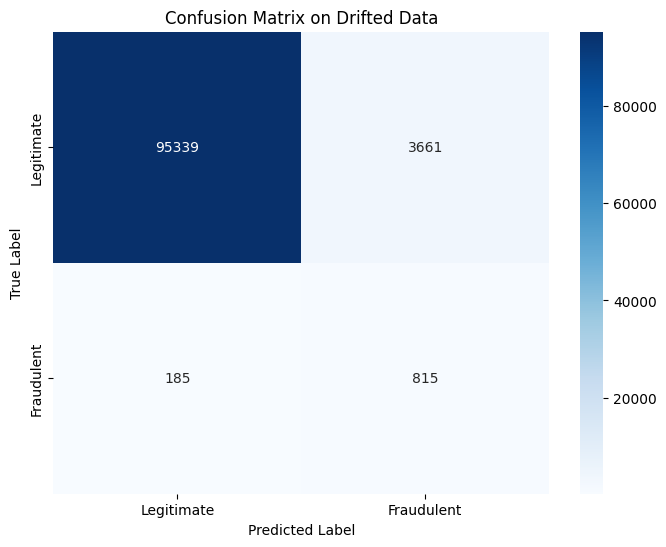

In [15]:
# Visualizing the confusion matrix for the drifted data
cm_drifted = confusion_matrix(y_drifted, y_pred_drifted)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_drifted, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Fraudulent'],
            yticklabels=['Legitimate', 'Fraudulent'])
plt.title('Confusion Matrix on Drifted Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()